In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from galton import galton_rvs
from galton import galton_rvs_ratio

In [11]:
from galton import n_nails
from galton import n_rows

theta_0 = -0.8
theta_1 = -0.6

# Density estimation with histograms

In [12]:
samples_0, _, scores_0, _ = galton_rvs(theta_0, n_runs=20000, random_state=1234)
p_estimated_0, _ = np.histogram(
    samples_0, bins=n_nails, range=(0, n_nails), density=True
)

samples_1, _, scores_1, _ = galton_rvs(theta_1, n_runs=20000, random_state=1234)
p_estimated_1, _ = np.histogram(
    samples_1, bins=n_nails, range=(0, n_nails), density=True
)

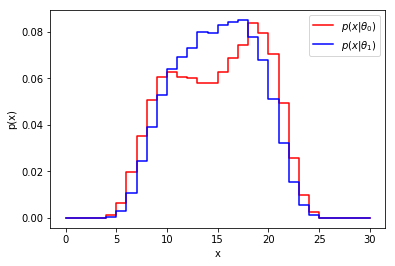

In [13]:
plt.step(
    range(len(p_estimated_0)), p_estimated_0, c="r", lw=1.5, label=r"$p(x|\theta_0)$"
)
plt.step(
    range(len(p_estimated_0)), p_estimated_1, c="b", lw=1.5, label=r"$p(x|\theta_1)$"
)

plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.show()

# NDE + SCANDAL

In [17]:
from galton import check_random_state
from keras.utils import to_categorical


def draw(n_samples, n_thetas=10, random_state=0):
    n_traces_per_theta = n_samples // n_thetas

    all_x = []
    all_t_xz = []
    all_thetas = []

    for k, theta in enumerate(np.linspace(-1.0, -0.4, n_thetas)):
        x, log_p_xz, t_xz, _ = galton_rvs(
            theta, n_runs=n_traces_per_theta, random_state=random_state + k
        )
        all_x.append(x)
        all_t_xz.append(t_xz)
        all_thetas.append(theta * np.ones(n_traces_per_theta))

    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_t_xz = np.array(all_t_xz).reshape(-1, 1)
    all_thetas = np.array(all_thetas).reshape(-1, 1)

    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)

    return all_x[choices], all_t_xz[choices], all_thetas[choices]

In [18]:
x, t_xz, theta = draw(10000)

In [19]:
n_features = 1 
hidden_size = 10
n_outputs = n_nails

In [21]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Lambda, dot
from keras.models import Model
from keras.utils import to_categorical
import keras.backend as K


def make_nde(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)

    model = Model(inputs=[theta], outputs=[phat_theta])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt)

    return model


def make_scandal(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)

    x = Input(shape=(n_outputs,))
    phat_x_theta = dot([x, phat_theta], axes=1)
    t_x = Lambda(
        lambda exp: K.gradients(K.log(exp[0]), [exp[1]])[0], output_shape=(n_features,)
    )([phat_x_theta, theta])

    model = Model(inputs=[theta, x], outputs=[phat_theta, t_x])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy", "mse"], optimizer=opt)

    return model

In [22]:
nde = make_nde()
nde.fit(theta, x, batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 0s 48us/step - loss: 3.1142
Epoch 2/50
10000/10000 [==============================] - 0s 42us/step - loss: 2.8591
Epoch 3/50
10000/10000 [==============================] - 0s 41us/step - loss: 2.8304
Epoch 4/50
10000/10000 [==============================] - 0s 43us/step - loss: 2.8221
Epoch 5/50
10000/10000 [==============================] - 0s 42us/step - loss: 2.8175
Epoch 6/50
10000/10000 [==============================] - 0s 42us/step - loss: 2.8147
Epoch 7/50
10000/10000 [==============================] - 0s 41us/step - loss: 2.8125
Epoch 8/50
10000/10000 [==============================] - 0s 46us/step - loss: 2.8108
Epoch 9/50
10000/10000 [==============================] - 0s 45us/step - loss: 2.8086
Epoch 10/50
10000/10000 [==============================] - 1s 59us/step - loss: 2.8065
Epoch 11/50
10000/10000 [==============================] - 0s 49us/step - loss: 2.8044
Epoch 12/50
10000/10000 [===========================

In [23]:
scandal = make_scandal()
scandal.fit([theta, x], [x, t_xz], batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 1s 62us/step - loss: 5.0866 - dense_4_loss: 3.2815 - lambda_1_loss: 1.8051
Epoch 2/50
10000/10000 [==============================] - 1s 56us/step - loss: 4.2705 - dense_4_loss: 3.0725 - lambda_1_loss: 1.1980
Epoch 3/50
10000/10000 [==============================] - 1s 54us/step - loss: 4.0218 - dense_4_loss: 2.9283 - lambda_1_loss: 1.0934
Epoch 4/50
10000/10000 [==============================] - 1s 62us/step - loss: 3.9089 - dense_4_loss: 2.8508 - lambda_1_loss: 1.0581
Epoch 5/50
10000/10000 [==============================] - 1s 89us/step - loss: 3.8511 - dense_4_loss: 2.8166 - lambda_1_loss: 1.0345
Epoch 6/50
10000/10000 [==============================] - 1s 60us/step - loss: 3.8178 - dense_4_loss: 2.8017 - lambda_1_loss: 1.0161
Epoch 7/50
10000/10000 [==============================] - 1s 61us/step - loss: 3.7951 - dense_4_loss: 2.7941 - lambda_1_loss: 1.0010
Epoch 8/50
10000/10000 [==============================] - 1s 61us/ste

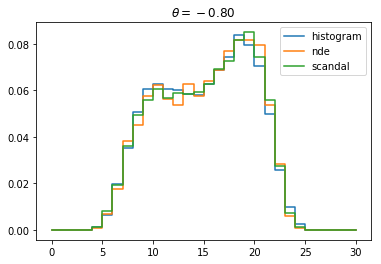

In [25]:
plt.step(range(n_nails), p_estimated_0, label="histogram")
plt.step(range(n_nails), nde.predict(np.array([theta_0])).ravel(), label="nde")
plt.step(
    range(n_nails),
    scandal.predict([np.array([[theta_0]]), np.zeros((1, n_nails))])[0][0],
    label="scandal",
)
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_0)
plt.show()

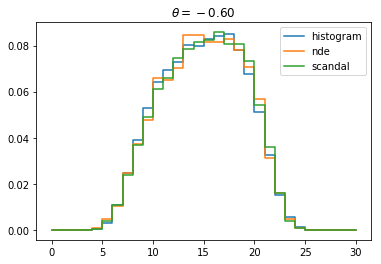

In [28]:
plt.step(range(n_nails), p_estimated_1, label="histogram")
plt.step(range(n_nails), nde.predict(np.array([theta_1])).ravel(), label="nde")
plt.step(
    range(n_nails),
    scandal.predict([np.array([[theta_1]]), np.zeros((1, n_nails))])[0][0],
    label="scandal",
)
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_1)
plt.show()

# CARL

In [ ]:
from carl.ratios import ClassifierRatio
from carl.ratios import ClassifierScoreRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import CalibratedClassifierScoreCV
from carl.learning import as_classifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
def make_carl(lr=0.001):
    inputs = Input(shape=(2 + n_outputs,))
    thetas = Lambda(lambda x: x[:, -2:], output_shape=(2,))(inputs)
    x = Lambda(lambda x: x[:, :-2], output_shape=(n_outputs,))(inputs)
    h = Dense(hidden_size, activation="tanh")(thetas)
    shat_thetas = Dense(n_outputs, activation="sigmoid")(h)

    shat_x_thetas = dot([x, shat_thetas], axes=1)

    model = Model(inputs=[inputs], outputs=[shat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=["binary_crossentropy"], optimizer=opt)
    return model

In [ ]:
from galton import check_random_state


def draw_parametrized(n_samples, n_thetas=10, random_state=0):
    n_traces_per_theta = n_samples // n_thetas 

    all_x = []
    all_theta = []
    all_y = []
    
    for k, theta in enumerate(np.linspace(-1.0, -0.4, n_thetas)):  # gilles: have a grid instead?
        x_0, _, _, _ = galton_rvs(
            theta, n_runs=n_traces_per_theta, random_state=random_state + k
        )
        x_1, _, _, _ = galton_rvs(
            theta_1, n_runs=n_traces_per_theta, random_state=random_state + k
        )
        all_x += x_0
        all_x += x_1
        all_theta += [[theta, theta_1]] * (n_traces_per_theta * 2)
        all_y += [0] * len(x_0)
        all_y += [1] * len(x_1)
        
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_theta = np.array(all_theta)
    all_x = np.hstack([all_x, all_theta])
    all_y = np.array(all_y)
    
    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)

    return all_x[choices], all_y[choices]

In [285]:
all_x, all_y = draw_parametrized(5000)

In [ ]:
carl = KerasRegressor(make_carl, epochs=50, batch_size=32, verbose=0)

carl.fit(all_x, all_y)

carl_calibrated = ClassifierScoreRatio(
    CalibratedClassifierScoreCV(carl, cv="prefit", method="isotonic")
)
carl_calibrated.fit(all_x, all_y.reshape(-1, 1))

In [ ]:
r_true = np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5])

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
r_carl = np.log(
    carl_calibrated.predict(
        np.hstack(
            [x_test, theta_0 * np.ones((n_nails, 1)), theta_1 * np.ones((n_nails, 1))]
        )
    )[0][5:-5]
)

plt.step(range(5, n_nails - 5), r_true, label="estimated")
plt.step(range(5, n_nails - 5), r_carl, label="carl")
plt.legend()
plt.show()

# ROLR + RASCAL

In [35]:
from galton import check_random_state
from itertools import product


def draw_ratio(n_samples, n_thetas=10, random_state=0):
    grid = list(
        product(np.linspace(-1.0, -0.4, n_thetas), np.linspace(-1.0, -0.4, n_thetas))
    )
    
    n_traces_per_theta = n_samples // len(grid)
    rng = check_random_state(random_state)

    all_x = []
    all_log_r_xz = []
    all_t_xz_0 = []
    all_thetas = []

    # draw from theta_1
    for theta_0, theta_1 in grid:
        x, log_p_xz_1, log_p_xz_0, _, t_xz_0, _ = galton_rvs_ratio(
            theta_1, theta_0, n_runs=n_traces_per_theta, random_state=rng
        )
        all_x.append(x)
        all_log_r_xz.append(log_p_xz_0 - log_p_xz_1)
        all_t_xz_0.append(t_xz_0)
        all_thetas.append(
            np.tile(np.array([theta_0, theta_1]), (n_traces_per_theta, 1))
        )

    # reshape
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_log_r_xz = np.array(all_log_r_xz).reshape(-1, 1)
    all_t_xz_0 = np.array(all_t_xz_0).reshape(-1, 1)
    all_thetas = np.vstack(all_thetas)

    choices = rng.choice(len(all_x), len(all_x), replace=False)

    return (
        all_x[choices],
        all_thetas[choices],
        all_log_r_xz[choices],
        all_t_xz_0[choices],
    )

In [36]:
x, thetas, log_r_xz, t_xz_0 = draw_ratio(10000, n_thetas=10)

In [38]:
from keras.losses import mean_squared_error
from keras.layers import concatenate


def make_rolr(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])

    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)

    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)

    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=["mse"], optimizer=opt)

    return model


def make_rascal(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])

    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)

    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)

    log_rhat_x_theta = dot([x, log_rhat_thetas], axes=1)
    t_x_0 = Lambda(
        lambda exp: K.gradients(exp[0], [exp[1]])[0], output_shape=(n_features,)
    )([log_rhat_x_theta, theta0])

    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas, t_x_0])
    opt = Adam(lr=lr)
    model.compile(loss=["mse", "mse"], loss_weights=[1.0, 0.5], optimizer=opt)

    return model

In [39]:
rolr = make_rolr()
rolr.fit([thetas[:, 0], 
          thetas[:, 1], 
          x], 
         np.exp(log_r_xz), 
         batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 0s 48us/step - loss: 0.2289
Epoch 2/50
10000/10000 [==============================] - 0s 37us/step - loss: 0.1773
Epoch 3/50
10000/10000 [==============================] - 0s 37us/step - loss: 0.1498
Epoch 4/50
10000/10000 [==============================] - 0s 39us/step - loss: 0.1367
Epoch 5/50
10000/10000 [==============================] - 0s 38us/step - loss: 0.1305
Epoch 6/50
10000/10000 [==============================] - 0s 40us/step - loss: 0.1267
Epoch 7/50
10000/10000 [==============================] - 0s 39us/step - loss: 0.1244
Epoch 8/50
10000/10000 [==============================] - 0s 37us/step - loss: 0.1225
Epoch 9/50
10000/10000 [==============================] - 0s 40us/step - loss: 0.1214
Epoch 10/50
10000/10000 [==============================] - 0s 41us/step - loss: 0.1209
Epoch 11/50
10000/10000 [==============================] - 1s 53us/step - loss: 0.1199
Epoch 12/50
10000/10000 [===========================

In [40]:
rascal = make_rascal()
rascal.fit([thetas[:, 0], 
            thetas[:, 1], 
            x], 
           [np.exp(log_r_xz), 
            t_xz_0], 
           batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 1s 61us/step - loss: 1.7410 - dot_3_loss: 0.2513 - lambda_4_loss: 2.9794
Epoch 2/50
10000/10000 [==============================] - 0s 46us/step - loss: 1.1157 - dot_3_loss: 0.1823 - lambda_4_loss: 1.8667
Epoch 3/50
10000/10000 [==============================] - 0s 46us/step - loss: 0.9274 - dot_3_loss: 0.1536 - lambda_4_loss: 1.5475
Epoch 4/50
10000/10000 [==============================] - 0s 45us/step - loss: 0.8798 - dot_3_loss: 0.1448 - lambda_4_loss: 1.4700
Epoch 5/50
10000/10000 [==============================] - 0s 49us/step - loss: 0.8487 - dot_3_loss: 0.1386 - lambda_4_loss: 1.4202
Epoch 6/50
10000/10000 [==============================] - 0s 46us/step - loss: 0.8185 - dot_3_loss: 0.1345 - lambda_4_loss: 1.3679
Epoch 7/50
10000/10000 [==============================] - 0s 48us/step - loss: 0.7871 - dot_3_loss: 0.1307 - lambda_4_loss: 1.3127
Epoch 8/50
10000/10000 [==============================] - 0s 45us/step - loss: 0.75

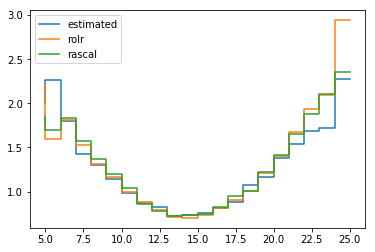

In [42]:
r_true = np.exp(np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5]))

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
r_rolr = rolr.predict([theta_0 * np.ones(n_nails), theta_1 * np.ones(n_nails), x_test])[
    5:-5
]
r_rascal = rascal.predict(
    [theta_0 * np.ones(n_nails), theta_1 * np.ones(n_nails), x_test]
)[0][5:-5]

plt.step(range(5, n_nails - 5), r_true, label="estimated")
plt.step(range(5, n_nails - 5), r_rolr, label="rolr")
plt.step(range(5, n_nails - 5), r_rascal, label="rascal")
plt.legend()
plt.show()

---

# Model comparison

In [44]:
def compute_mse(p_train, p_estimated):
    p_ratio_train = np.log(p_train[0]) - np.log(p_train[1])
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse), np.isnan(mse))] = 0.
    mse = np.dot(mse ** 2, p_estimated[1])
    return mse


def compute_mse_ratio(ratio, p_estimated, log=True):
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    if log:
        p_ratio_train = np.log(ratio)
    else:
        p_ratio_train = ratio
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse), np.isnan(mse))] = 0.
    mse = np.dot(mse ** 2, p_estimated[1])
    return mse

In [ ]:
mses_nde = []
mses_scandal = []
mses_carl = []
mses_rolr = []
mses_rascal = []

p_estimated = np.array([p_estimated_0, p_estimated_1])
samples_size = [100, 200, 500, 1000, 2000, 5000, 10000]
x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)

for n in samples_size:
    print("{0} Sample".format(n))
    
    # NDE - SCANDAL
    x, t_xz, theta = draw(n)
    nde = make_nde()
    nde.fit(theta, x, batch_size=32, epochs=50, verbose=0)
    scandal = make_scandal()
    scandal.fit([theta, x], [x, t_xz], batch_size=32, epochs=50, verbose=0)
    
    nde_pred = nde.predict([theta_0, theta_1])
    scandal_pred = scandal.predict(
        [np.array([[theta_0], [theta_1]]), np.zeros((2, n_nails))]
    )[0]
    mse_nde = compute_mse(nde_pred, p_estimated)
    mse_scandal = compute_mse(scandal_pred, p_estimated)
    
    # CARL
    all_x, all_y = draw_parametrized(n)
    x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)

    carl = KerasRegressor(make_carl, epochs=50, batch_size=32, verbose=0)
    carl.fit(all_x, all_y)
    carl_calibrated = ClassifierScoreRatio(
        CalibratedClassifierScoreCV(
            carl, cv="prefit", method="histogram", bins=10 if n < 1000 else 20
        )
    )
    carl_calibrated.fit(all_x, all_y.reshape(-1, 1))
    
    carl_pred = carl_calibrated.predict(
        np.hstack(
            [x_test, theta_0 * np.ones((n_nails, 1)), theta_1 * np.ones((n_nails, 1))]
        )
    )[0][5:-5]
    mse_carl = compute_mse_ratio(carl_pred.flatten(), p_estimated[:, 5:-5], log=True)
    
    # ROLR - RASCAL
    x, thetas, log_r_xz, t_xz_0 = draw_ratio(n, n_thetas=10)
    rolr = make_rolr()
    rolr.fit(
        [thetas[:, 0], thetas[:, 1], x],
        np.exp(log_r_xz),
        batch_size=32,
        epochs=50,
        verbose=0,
    )
    rascal = make_rascal()
    rascal.fit(
        [thetas[:, 0], thetas[:, 1], x],
        [np.exp(log_r_xz), t_xz_0],
        batch_size=32,
        epochs=50,
        verbose=0,
    )
    
    rolr_pred = rolr.predict(
        [theta_0 * np.ones(n_nails), theta_1 * np.ones(n_nails), x_test]
    )[5:-5]
    rascal_pred = rascal.predict(
        [theta_0 * np.ones(n_nails), theta_1 * np.ones(n_nails), x_test]
    )[0][5:-5]
    
    mse_rolr = compute_mse_ratio(rolr_pred.flatten(), p_estimated[:, 5:-5], log=True)
    mse_rascal = compute_mse_ratio(
        rascal_pred.flatten(), p_estimated[:, 5:-5], log=True
    )
    
    mses_nde.append(mse_nde)
    mses_rascal.append(mse_rascal)
    mses_carl.append(mse_carl)
    mses_rolr.append(mse_rolr)
    mses_scandal.append(mse_scandal)

In [298]:
from utils import calculate_height, adjust_margins

In [299]:
colors     = ['orange', 'darkgreen',  'red', 'mediumblue', '#be96ff', '#CC002E']
linestyles = [     ':',        '--',  ':',         '-.',      '-.',      '--']
linewidths = [1.5 if ls == ':' else 1.5 for ls in linestyles]
markers    = [None] + ['o'] * 5

In [300]:
mses_nde = np.array(mses_nde)
mses_scandal = np.array(mses_scandal)
mses_rolr = np.array(mses_rolr)
mses_rascal = np.array(mses_rascal)
mses_carl = np.array(mses_carl)

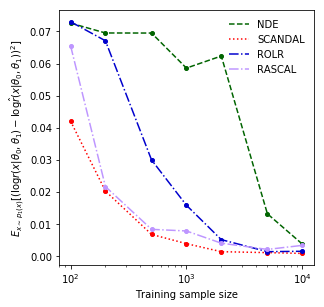

In [301]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,extra_top_space=False)))
ax = plt.gca()
samples_size = [100,200,500,1000,2000,5000,10000]

mses = [mses_nde, mses_scandal, mses_rolr, mses_rascal]
labels = ['NDE', 'SCANDAL', 'ROLR', 'RASCAL']
s = 1
plt.plot(samples_size, mses[s-1], 
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

s = 2
plt.plot(samples_size, mses[s-1],
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

s = 3
plt.plot(samples_size, mses[s-1],
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

s = 4
plt.plot(samples_size, mses[s-1],
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

ax.set_xscale("log", nonposx='clip')
plt.xlabel(r"Training sample size")
plt.ylabel(r'$E_{x\sim p_1(x)} [(\log r(x|\theta_0, \theta_1) - \log \hat{r}(x|\theta_0, \theta_1))^2]$')
plt.legend(frameon=False)

adjust_margins(1,4.5,extra_top_space=False)
plt.savefig('plinko_models_comparison.pdf')